In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp

import sys
sys.path.append('../')

from environment.maze import MetaMaze

jax.device_count(), jax.devices()

In [ ]:
print('hello')

In [2]:
rng = jax.random.PRNGKey(1)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# Create the Pendulum-v1 environment
env = MetaMaze(maze_size=13, rf_size=3)
env_params = env.default_params

In [3]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([ 1,  0,  1,  0,  0,  0,  1,  0,  1,  7,  7, -1, -1], dtype=int32),
 EnvState(last_action=Array(0, dtype=int32, weak_type=True), last_reward=Array(0., dtype=float32, weak_type=True), pos=Array([7, 7], dtype=int32), goal=Array([11,  7], dtype=int32), time=Array(0., dtype=float32, weak_type=True)))

(<Figure size 640x480 with 1 Axes>, <Axes: >)

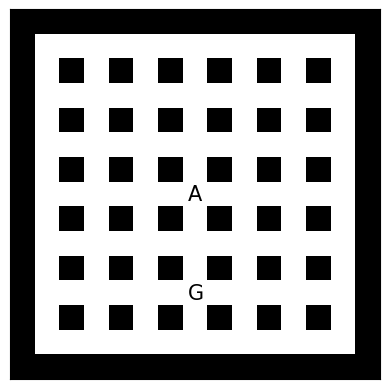

In [4]:
env.render(state, env_params)

In [232]:
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)
obs, state, reward, done, info = env.step(key_step, state, 2)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

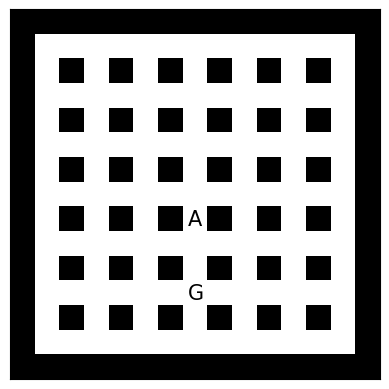

In [233]:
env.render(state, env_params)

## Visualize training curves

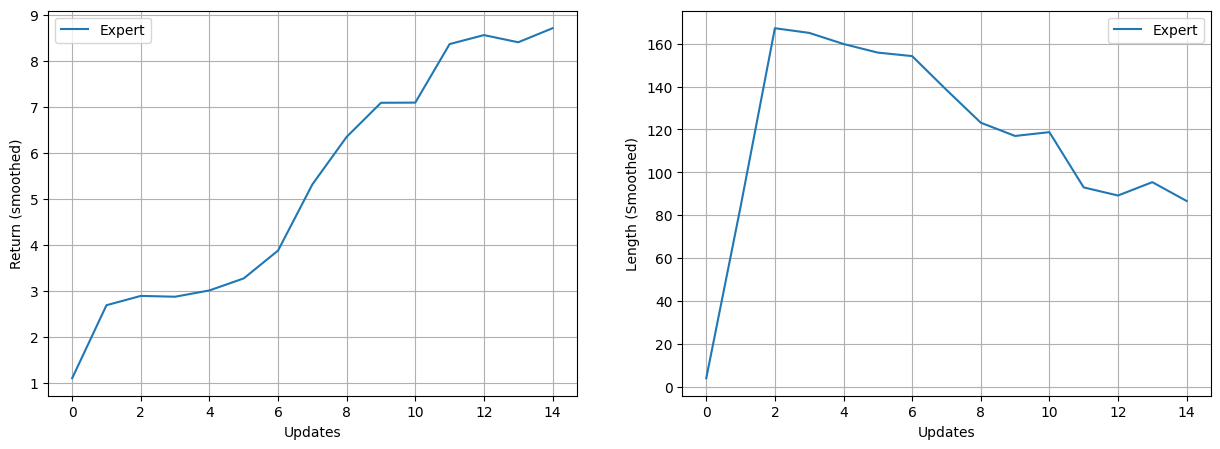

In [95]:
metric_path = '/data/draco/cleain/imitation_gap_minigrid/logs_rl/20231201_110030/training_metrics_4.pkl'

import pickle
# Load the data from the pickle file
with open(metric_path, 'rb') as f:
    out = pickle.load(f)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
window_size = 1

fig.add_subplot(1,2,1)
smoothed_return = jnp.convolve(out["returned_episode_returns"].reshape(-1),
                               jnp.ones(window_size) / window_size,
                               mode='valid')

plt.plot(smoothed_return, label='Expert')
plt.xlabel("Updates")
plt.ylabel("Return (smoothed)")
plt.legend()
plt.grid('on')

smoothed_length = jnp.convolve(out["returned_episode_lengths"].reshape(-1),
                               jnp.ones(window_size) / window_size,
                               mode='valid')

fig.add_subplot(1,2,2)
plt.plot(smoothed_length, label='Expert')
plt.xlabel("Updates")
plt.ylabel("Length (Smoothed)")
plt.grid('on')
plt.legend();


## Visualize learned policy

In [ ]:
from IPython.display import clear_output
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image

In [96]:
from model.rnn_policy import ScannedRNN, ActorCriticRNN
import json

with open('/data/draco/cleain/imitation_gap_minigrid/logs_rl/20231128_144348/args.json', 'r') as file:
    config = json.load(file)

with open('/data/draco/cleain/imitation_gap_minigrid/logs_rl/20231128_144348/params_4.pkl', 'rb') as file:
    params = pickle.load(file)

network = ActorCriticRNN(env.action_space(env_params).n, config=config)


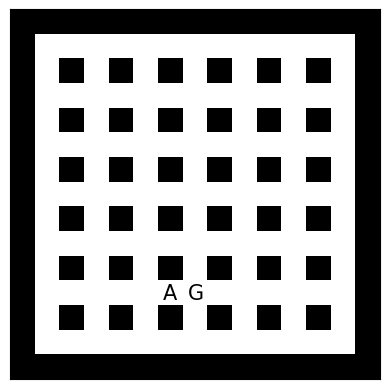

In [99]:
tt = 0
imgs = []

rng = jax.random.PRNGKey(1)
# rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# Create the Pendulum-v1 environment
env = MetaMaze(**config['params'])
env_params = env.default_params

obs, env_state = env.reset(key_reset, env_params)
done = False
hstate = ScannedRNN.initialize_carry((1, 128))

while not done and tt < 200:

    fig, _ = env.render(env_state, env_params)
    plt.show()

    rng, _rng = jax.random.split(rng)

    # SELECT ACTION
    ac_in = (obs[jnp.newaxis,jnp.newaxis, :], jnp.array([done])[jnp.newaxis,jnp.newaxis, :])
    hstate, pi, value = network.apply(params, hstate, ac_in)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)
    value, action, log_prob = (
        value.squeeze(0),
        action.squeeze(0),
        log_prob.squeeze(0),
    )

    # STEP ENV
    rng, _rng = jax.random.split(rng)

    # Update the environment
    _, env_state, reward, done, info = env.step(_rng, env_state, action[0], env_params)

    # Get the observation
    obs = env.get_obs(env_state, env_params, config['is_expert'])

    tt += 1
    
    canvas = FigureCanvasAgg(fig)
    canvas.draw()

    # Get the image buffer as a PIL image
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    imgs.append(pil_image)

    clear_output(wait=True)


In [ ]:
# Save gif
gif_file = f"../animation/ex_{key_reset[0]}.gif"
imgs[0].save(gif_file, save_all=True, append_images=imgs, duration=100, loop=0)